<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Binary-Class-(배경이냐-아니냐)" data-toc-modified-id="Binary-Class-(배경이냐-아니냐)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Binary Class (배경이냐 아니냐)</a></span></li><li><span><a href="#Multi-Class-(Number-of-classes-:-8-배경포함)" data-toc-modified-id="Multi-Class-(Number-of-classes-:-8-배경포함)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Multi Class (Number of classes : 8 배경포함)</a></span><ul class="toc-item"><li><span><a href="#Total" data-toc-modified-id="Total-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Total</a></span></li><li><span><a href="#By-classes" data-toc-modified-id="By-classes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>By classes</a></span></li><li><span><a href="#Class-1" data-toc-modified-id="Class-1-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Class 1</a></span></li><li><span><a href="#Class-2" data-toc-modified-id="Class-2-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Class 2</a></span></li><li><span><a href="#Class-3" data-toc-modified-id="Class-3-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Class 3</a></span></li><li><span><a href="#Class-4" data-toc-modified-id="Class-4-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Class 4</a></span></li><li><span><a href="#Class-5" data-toc-modified-id="Class-5-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Class 5</a></span></li><li><span><a href="#Class-6" data-toc-modified-id="Class-6-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Class 6</a></span></li><li><span><a href="#Class-7" data-toc-modified-id="Class-7-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Class 7</a></span></li></ul></li></ul></div>

In [1]:
import json
import matplotlib.pyplot as plt
import os 

In [2]:
log_dir = '../log/'
log_list = os.listdir(log_dir)

In [3]:
log_list

['UNET_3D_0_info.json',
 'UNET_3D_10_128_8_info.json',
 'UNET_3D_11_128_8_info.json',
 'UNET_3D_12_128_1_info.json',
 'UNET_3D_13_128_1_info.json',
 'UNET_3D_14_128_7_info.json',
 'UNET_3D_15_128_7_info.json',
 'UNET_3D_16_128_7_info.json',
 'UNET_3D_17_128_7_info.json',
 'UNET_3D_18_128_7_info.json',
 'UNET_3D_19_128_7_info.json',
 'UNET_3D_20_96_7_info.json',
 'UNET_3D_21_96_7_info.json',
 'UNET_3D_22_info.json',
 'UNET_3D_9_128_8_info.json',
 'UNET_3D_class1_info.json',
 'UNET_3D_class2_info.json',
 'UNET_3D_class3_info.json',
 'UNET_3D_class4_info.json',
 'UNET_3D_class5_info.json',
 'UNET_3D_class6_info.json',
 'UNET_3D_class7_info.json',
 'UNET_3D_Total_info.json']

# Binary Class (배경이냐 아니냐)

In [4]:
binary_class = log_list[4]
print('binary_class: ',binary_class)

f = open(os.path.join(log_dir,binary_class))
j = json.load(f)
print("j['HISTORY'].keys(): ",j['HISTORY'].keys())

binary_class:  UNET_3D_13_128_1_info.json
j['HISTORY'].keys():  dict_keys(['epochs', 'steps', 'verbose', 'do_validation', 'metrics', 'LOSS', 'DSC_TOTAL', 'VAL_LOSS', 'VAL_DSC_TOTAL'])


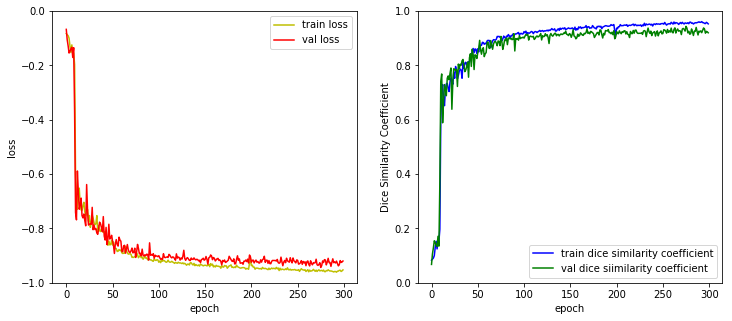

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(j['HISTORY']['LOSS'], 'y', label='train loss')
ax[0].plot(j['HISTORY']['VAL_LOSS'], 'r', label='val loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_ylim([-1,0])
ax[0].legend(loc='upper right')

ax[1].plot(j['HISTORY']['DSC_TOTAL'], 'b', label='train dice similarity coefficient')
ax[1].plot(j['HISTORY']['VAL_DSC_TOTAL'], 'g', label='val dice siimilarity coefficient')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Dice Similarity Coefficient')
ax[1].set_ylim([0,1])
ax[1].legend(loc='lower right')

# Multi Class (Number of classes : 8 배경포함)

In [4]:
multi_class = 'UNET_3D_22_info.json'
print('multi_class: ',multi_class)

f = open(os.path.join(log_dir,multi_class))
j = json.load(f)
print("j['HISTORY'].keys(): ",j['HISTORY'].keys())

multi_class:  UNET_3D_22_info.json
j['HISTORY'].keys():  dict_keys(['epochs', 'steps', 'verbose', 'do_validation', 'metrics', 'LOSS', 'DSC_TOTAL', 'VAL_LOSS', 'VAL_DSC_TOTAL', 'DSC0', 'DSC1', 'DSC2', 'DSC3', 'DSC4', 'DSC5', 'DSC6', 'DSC7', 'VAL_DSC0', 'VAL_DSC1', 'VAL_DSC2', 'VAL_DSC3', 'VAL_DSC4', 'VAL_DSC5', 'VAL_DSC6', 'VAL_DSC7'])


## Total

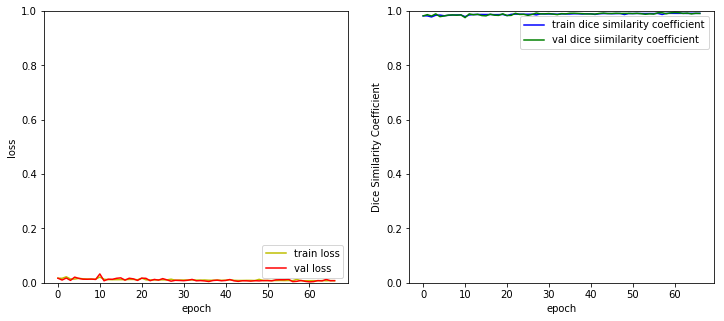

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(j['HISTORY']['LOSS'], 'y', label='train loss')
ax[0].plot(j['HISTORY']['VAL_LOSS'], 'r', label='val loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_ylim([0,1])
ax[0].legend(loc='lower right')

ax[1].plot(j['HISTORY']['DSC_TOTAL'], 'b', label='train dice similarity coefficient')
ax[1].plot(j['HISTORY']['VAL_DSC_TOTAL'], 'g', label='val dice siimilarity coefficient')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Dice Similarity Coefficient')
ax[1].set_ylim([0,1])
ax[1].legend(loc='upper right')

## By classes

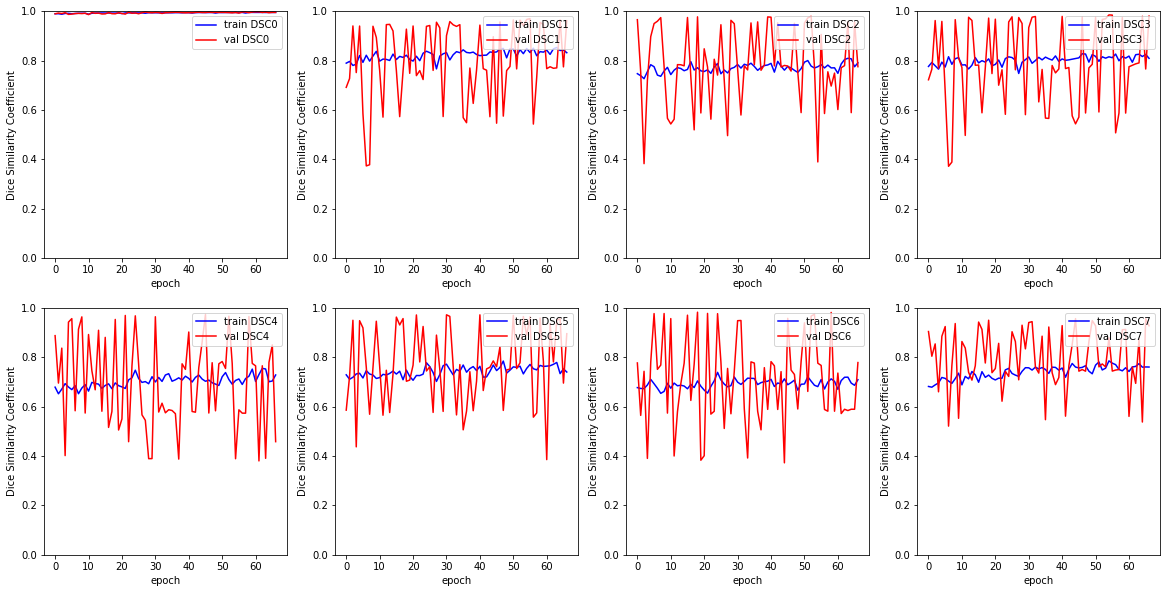

In [6]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
for i in range(8):
    ax[i//4,i%4].plot(j['HISTORY']['DSC{}'.format(i)], 'b', label='train DSC{}'.format(i))
    ax[i//4,i%4].plot(j['HISTORY']['VAL_DSC{}'.format(i)], 'r', label='val DSC{}'.format(i))
    ax[i//4,i%4].set_xlabel('epoch')
    ax[i//4,i%4].set_ylabel('Dice Similarity Coefficient')
    ax[i//4,i%4].legend(loc='upper right')
    ax[i//4,i%4].set_ylim([0,1])

## Class 1

In [11]:
class_1 = 'UNET_3D_class1_info.json'
print('class 1: ',class_1)

f = open(os.path.join(log_dir,class_1))
j = json.load(f)
print("j['HISTORY'].keys(): ",j['HISTORY'].keys())

class 1:  UNET_3D_class1_info.json
j['HISTORY'].keys():  dict_keys(['epochs', 'steps', 'verbose', 'do_validation', 'metrics', 'LOSS', 'DSC_TOTAL', 'VAL_LOSS', 'VAL_DSC_TOTAL'])


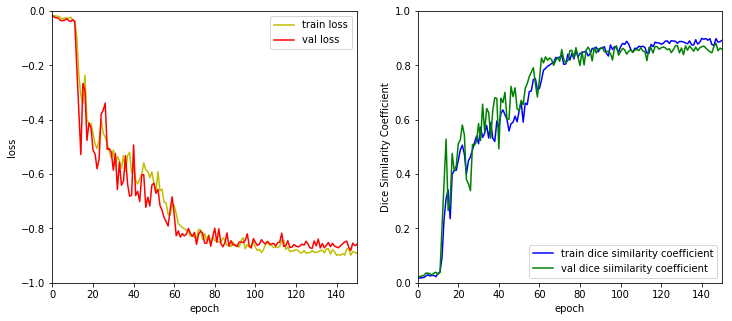

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(j['HISTORY']['LOSS'], 'y', label='train loss')
ax[0].plot(j['HISTORY']['VAL_LOSS'], 'r', label='val loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_ylim([-1,0])
ax[0].set_xlim([0,150])
ax[0].legend(loc='upper right')

ax[1].plot(j['HISTORY']['DSC_TOTAL'], 'b', label='train dice similarity coefficient')
ax[1].plot(j['HISTORY']['VAL_DSC_TOTAL'], 'g', label='val dice siimilarity coefficient')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Dice Similarity Coefficient')
ax[1].set_ylim([0,1])
ax[1].set_xlim([0,150])
ax[1].legend(loc='lower right')

## Class 2

In [15]:
class_2 = 'UNET_3D_class2_info.json'
print('class 1: ',class_2)

f = open(os.path.join(log_dir,class_2))
j = json.load(f)
print("j['HISTORY'].keys(): ",j['HISTORY'].keys())

class 1:  UNET_3D_class2_info.json
j['HISTORY'].keys():  dict_keys(['epochs', 'steps', 'verbose', 'do_validation', 'metrics', 'LOSS', 'DSC_TOTAL', 'VAL_LOSS', 'VAL_DSC_TOTAL'])


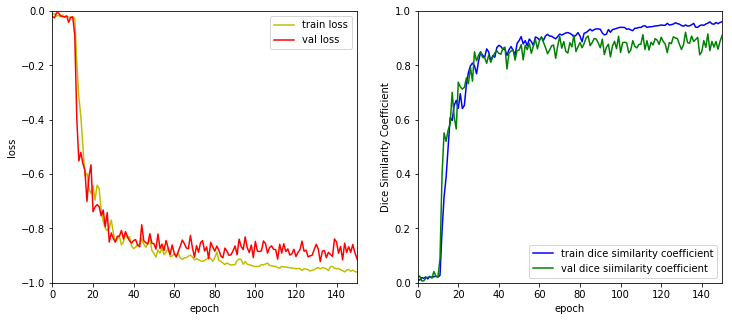

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(j['HISTORY']['LOSS'], 'y', label='train loss')
ax[0].plot(j['HISTORY']['VAL_LOSS'], 'r', label='val loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_ylim([-1,0])
ax[0].set_xlim([0,150])
ax[0].legend(loc='upper right')

ax[1].plot(j['HISTORY']['DSC_TOTAL'], 'b', label='train dice similarity coefficient')
ax[1].plot(j['HISTORY']['VAL_DSC_TOTAL'], 'g', label='val dice siimilarity coefficient')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Dice Similarity Coefficient')
ax[1].set_ylim([0,1])
ax[1].set_xlim([0,150])
ax[1].legend(loc='lower right')

## Class 3

In [89]:
class_3 = log_list[1]
print('class 1: ',class_3)

f = open(os.path.join(log_dir,class_3))
j = json.load(f)
print("j['HISTORY'].keys(): ",j['HISTORY'].keys())

class 1:  UNET_3D_11_128_8_c3_info.json
j['HISTORY'].keys():  dict_keys(['epochs', 'steps', 'verbose', 'do_validation', 'metrics', 'LOSS', 'DSC_TOTAL', 'VAL_LOSS', 'VAL_DSC_TOTAL'])


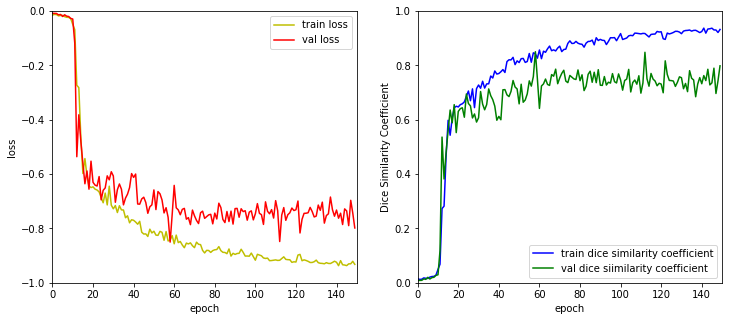

In [90]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(j['HISTORY']['LOSS'], 'y', label='train loss')
ax[0].plot(j['HISTORY']['VAL_LOSS'], 'r', label='val loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_ylim([-1,0])
ax[0].set_xlim([0,150])
ax[0].legend(loc='upper right')

ax[1].plot(j['HISTORY']['DSC_TOTAL'], 'b', label='train dice similarity coefficient')
ax[1].plot(j['HISTORY']['VAL_DSC_TOTAL'], 'g', label='val dice siimilarity coefficient')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Dice Similarity Coefficient')
ax[1].set_ylim([0,1])
ax[1].set_xlim([0,150])
ax[1].legend(loc='lower right')

## Class 4

In [77]:
class_4 = log_list[5]
print('class 1: ',class_4)

f = open(os.path.join(log_dir,class_4))
j = json.load(f)
print("j['HISTORY'].keys(): ",j['HISTORY'].keys())

class 1:  UNET_3D_6_128_8_c4_info.json
j['HISTORY'].keys():  dict_keys(['epochs', 'steps', 'verbose', 'do_validation', 'metrics', 'LOSS', 'DSC_TOTAL', 'VAL_LOSS', 'VAL_DSC_TOTAL'])


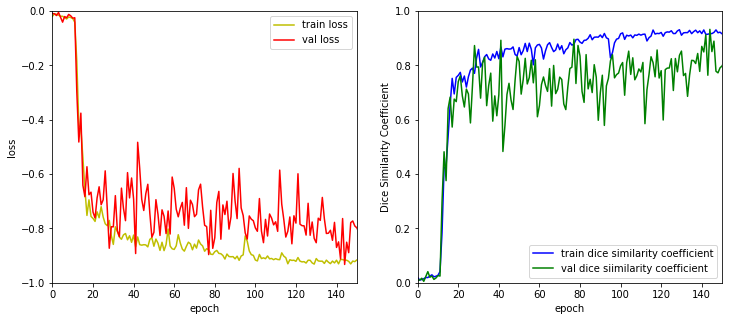

In [78]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(j['HISTORY']['LOSS'], 'y', label='train loss')
ax[0].plot(j['HISTORY']['VAL_LOSS'], 'r', label='val loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_ylim([-1,0])
ax[0].set_xlim([0,150])
ax[0].legend(loc='upper right')

ax[1].plot(j['HISTORY']['DSC_TOTAL'], 'b', label='train dice similarity coefficient')
ax[1].plot(j['HISTORY']['VAL_DSC_TOTAL'], 'g', label='val dice siimilarity coefficient')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Dice Similarity Coefficient')
ax[1].set_ylim([0,1])
ax[1].set_xlim([0,150])
ax[1].legend(loc='lower right')

## Class 5

In [79]:
class_5 = log_list[6]
print('class 1: ',class_5)

f = open(os.path.join(log_dir,class_5))
j = json.load(f)
print("j['HISTORY'].keys(): ",j['HISTORY'].keys())

class 1:  UNET_3D_7_128_8_c5_info.json
j['HISTORY'].keys():  dict_keys(['epochs', 'steps', 'verbose', 'do_validation', 'metrics', 'LOSS', 'DSC_TOTAL', 'VAL_LOSS', 'VAL_DSC_TOTAL'])


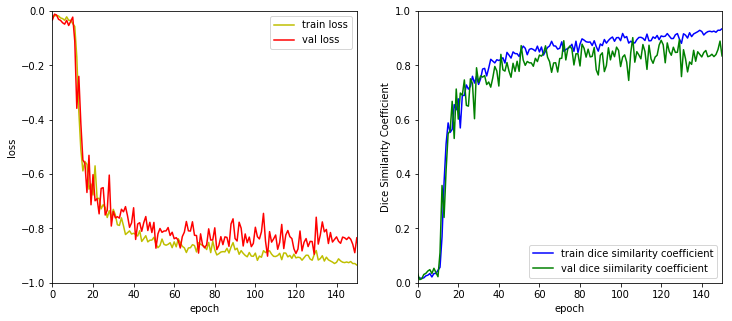

In [80]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(j['HISTORY']['LOSS'], 'y', label='train loss')
ax[0].plot(j['HISTORY']['VAL_LOSS'], 'r', label='val loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_ylim([-1,0])
ax[0].set_xlim([0,150])
ax[0].legend(loc='upper right')

ax[1].plot(j['HISTORY']['DSC_TOTAL'], 'b', label='train dice similarity coefficient')
ax[1].plot(j['HISTORY']['VAL_DSC_TOTAL'], 'g', label='val dice siimilarity coefficient')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Dice Similarity Coefficient')
ax[1].set_ylim([0,1])
ax[1].set_xlim([0,150])
ax[1].legend(loc='lower right')

## Class 6

In [81]:
class_6 = log_list[7]
print('class 1: ',class_6)

f = open(os.path.join(log_dir,class_6))
j = json.load(f)
print("j['HISTORY'].keys(): ",j['HISTORY'].keys())

class 1:  UNET_3D_8_128_8_c6_info.json
j['HISTORY'].keys():  dict_keys(['epochs', 'steps', 'verbose', 'do_validation', 'metrics', 'LOSS', 'DSC_TOTAL', 'VAL_LOSS', 'VAL_DSC_TOTAL'])


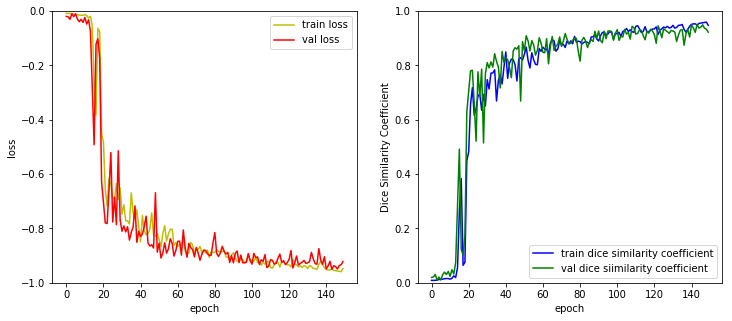

In [82]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(j['HISTORY']['LOSS'], 'y', label='train loss')
ax[0].plot(j['HISTORY']['VAL_LOSS'], 'r', label='val loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_ylim([-1,0])
ax[0].legend(loc='upper right')

ax[1].plot(j['HISTORY']['DSC_TOTAL'], 'b', label='train dice similarity coefficient')
ax[1].plot(j['HISTORY']['VAL_DSC_TOTAL'], 'g', label='val dice siimilarity coefficient')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Dice Similarity Coefficient')
ax[1].set_ylim([0,1])
ax[1].legend(loc='lower right')

## Class 7

In [83]:
class_7 = log_list[8]
print('class 1: ',class_7)

f = open(os.path.join(log_dir,class_7))
j = json.load(f)
print("j['HISTORY'].keys(): ",j['HISTORY'].keys())

class 1:  UNET_3D_9_128_8_c7_info.json
j['HISTORY'].keys():  dict_keys(['epochs', 'steps', 'verbose', 'do_validation', 'metrics', 'LOSS', 'DSC_TOTAL', 'VAL_LOSS', 'VAL_DSC_TOTAL'])


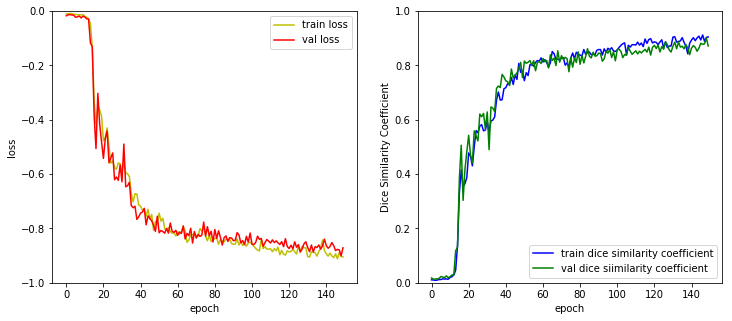

In [84]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(j['HISTORY']['LOSS'], 'y', label='train loss')
ax[0].plot(j['HISTORY']['VAL_LOSS'], 'r', label='val loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_ylim([-1,0])
ax[0].legend(loc='upper right')

ax[1].plot(j['HISTORY']['DSC_TOTAL'], 'b', label='train dice similarity coefficient')
ax[1].plot(j['HISTORY']['VAL_DSC_TOTAL'], 'g', label='val dice siimilarity coefficient')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Dice Similarity Coefficient')
ax[1].set_ylim([0,1])
ax[1].legend(loc='lower right')